<a id='Table_Contents'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">Table of Contents</h2>

* [Table of Contents](#Table_Contents)
* [1. Problem Definition](#Problem_Definition)
* [2. The Approach](#Approach)
* [3. Data](#Data)
    - [1 Data Scription](#Data_Description)
    - [2 Load Libraries](#Load_Libraries)
    - [3 Read Dataset](#Read_Dataset)
    - [4 Types of variables](#Types_of_variables)
    - [5 Target Label](#Target_Label) 
    - [6 Data Quality](#Data_Quality)
* [4. EDA](#EDA)
    - [1 Target](#Target)
    - [2 Numerical Features](#Numerical_Features)
    - [3 Categorical Variables](#Categorical_Variables)
    - [4 Dependency between features](#Dependency_between_features)
    - [5 Correlation between features](#Correlation_between_features) 
    - [6 EDA Summery](#EDA_Summery)
* [5. Data Preprocessing](#Feature_Engineering)
    - [1 Train/Test data ready for modeling](#Train/Test_data_ready_for_modeling)
    - [2 Categorical encoders tuning on ICD10](#Categorical_encoders_tuning_on_ICD10)
* [6. Model Building](#Model_Building)
    - [1 Random Forest and Random Search](#Random_Forest_and_Random_Search)
    - [2 XGBoost Classifer and Random Search](#XGBoost_Classifer_and_Random_Search)
    - [3 Model selection](#Model_selection) 
    - [4 XGBoost Classifier and SHAP](#XGBoost_Classifier_and_SHAP)
    - [5 Summery](#Summery)
* [7. Prediction using unseen test data](#Deploy)
    - [1 Test data preparation](#Test_data_preparation)
    - [2 Prediction](#Prediction)


<a id='Problem_Definition'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">1.Problem Definition</h2>

The goal of this project will be to build a machine learning model that will be used to predict whether a member (i.e., covered life) will have a particular surgery or not. Thus, the output of the project should be [commented] code used to develop the model in addition to predictions on a testing dataset.<br>

The reason we need to predict surgeries is because we are setting up a program that will provide a travel benefit to those most likely to have this particular surgery. Reaching out these members and setting up this benefit can be expensive, so we need to be pretty confident that the members we are identifying are planning to get this surgery. Due to staffing and cost constraints, we are able to outreach to 100 members.

<a id='Approach'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">2. Approach</h2>

Build a binary classification model based on a simulated dataset, performing 
- data cleaning, handling missing values, and exploratory analysis, 
- Feature engineering and selection, 
- Model selection, training and evalution,
- Predict unseen new data


<a id='Data'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">3.Data</h2>

<a id='Data_Description'></a>
<h3 style="color:blue">3.1 Data Description</h3>

The simulated data set is downloaded from here: https://github.com/dsinterview/surgeries/tree/main/data

<a id='Load_Libraries'></a>
<h3 style="color:blue">3.2 Load Libraries</h3>

In [1]:
import pandas as pd
import requests
import io
import seaborn as sns
import math    
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import phik
from phik import resources, report
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.metrics import make_scorer, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    auc,
    roc_curve,
    f1_score,
    accuracy_score,
    classification_report,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve
)
from xgboost import XGBClassifier
from rfpimp import permutation_importances
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
import shap

<a id='Read_Dataset'></a>
<h3 style="color:blue">3.3 Read Dataset</h3>

In [2]:
import urllib.request

urls = ['github_data']

dfs = []

for url in urls:
    with urllib.request.urlopen(url) as f:
        df = pd.read_csv(f, sep=" ")
        dfs.append(df)

claims_file, locations_file, surgeries_file = dfs

In [3]:
claims_file

,MEMBER_ID,CLAIM_ID,LOS_CODE
0,V2045033839,DWD-1644TI185,2
1,U3368542783,JAV-0750KB107,11
2,V7794221118,KNZ-3862GG349,11
3,L9612031535,XPI-7191FS708,22
4,R7118311293,OEV-2571HQ666,11
...,...,...,...
91781,G8557833383,ENK-3644DL357,22
91782,J3362122077,KCT-9975SN865,11
91783,V2158224466,JLN-6518LE094,2
91784,J6976523558,SKG-4849JH517,22


In [4]:
claims_file.nunique()

MEMBER_ID    36941
CLAIM_ID     91786
LOS_CODE         6
dtype: int64

Each member has multiple claims. 

In [5]:
result = claims_file.groupby('MEMBER_ID')['LOS_CODE'].nunique() > 1
member_ids_with_different_los_codes = result[result].index.tolist()

In [6]:
len(member_ids_with_different_los_codes)

20149

In [7]:
result = claims_file.groupby('MEMBER_ID')['LOS_CODE'].nunique()
result

MEMBER_ID
A1014131395    2
A1022527992    2
A1027816079    1
A1036541754    2
A10430M9046    2
              ..
Z9967436999    1
Z9967628036    1
Z9985334029    3
Z9996638093    1
Z9999048765    3
Name: LOS_CODE, Length: 36941, dtype: int64

Each claims with same member could have different service location.

In [8]:
locations_file

,LOS_DESCR,LOS_CODE
0,Emergency Room,23
1,Outpatient,22
2,Inpatient,21
3,Professional,11
4,Urgent Care,20
5,Hospice,34
6,Telehealth,2


There are 6 types of Service Location.

In [9]:
# merge claims_file and locations_file
merged = claims_file.merge(locations_file, how='left', on='LOS_CODE')
merged

,MEMBER_ID,CLAIM_ID,LOS_CODE,LOS_DESCR
0,V2045033839,DWD-1644TI185,2,Telehealth
1,U3368542783,JAV-0750KB107,11,Professional
2,V7794221118,KNZ-3862GG349,11,Professional
3,L9612031535,XPI-7191FS708,22,Outpatient
4,R7118311293,OEV-2571HQ666,11,Professional
...,...,...,...,...
91781,G8557833383,ENK-3644DL357,22,Outpatient
91782,J3362122077,KCT-9975SN865,11,Professional
91783,V2158224466,JLN-6518LE094,2,Telehealth
91784,J6976523558,SKG-4849JH517,22,Outpatient


In [10]:
# perform one-hot encoding on the LOS_DESCR column
one_hot_merged = pd.get_dummies(merged[['LOS_DESCR']], prefix='LOS_DESCR')

# merge the one-hot-encoded dataframe with the original dataframe
df = pd.concat([merged, one_hot_merged], axis=1)


# drop the original LOS_DESCR column
df = df.drop(['LOS_DESCR','LOS_CODE'], axis=1)

# print the resulting dataframe
df

,MEMBER_ID,CLAIM_ID,LOS_DESCR_Emergency Room,LOS_DESCR_Inpatient,LOS_DESCR_Outpatient,LOS_DESCR_Professional,LOS_DESCR_Telehealth,LOS_DESCR_Urgent Care
0,V2045033839,DWD-1644TI185,0,0,0,0,1,0
1,U3368542783,JAV-0750KB107,0,0,0,1,0,0
2,V7794221118,KNZ-3862GG349,0,0,0,1,0,0
3,L9612031535,XPI-7191FS708,0,0,1,0,0,0
4,R7118311293,OEV-2571HQ666,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
91781,G8557833383,ENK-3644DL357,0,0,1,0,0,0
91782,J3362122077,KCT-9975SN865,0,0,0,1,0,0
91783,V2158224466,JLN-6518LE094,0,0,0,0,1,0
91784,J6976523558,SKG-4849JH517,0,0,1,0,0,0


In [11]:

df = df.groupby('MEMBER_ID').agg(
            num_claims=('CLAIM_ID', 'nunique'),
            LOS_DESCR_Emergency_Room=('LOS_DESCR_Emergency Room','sum'),
            LOS_DESCR_Inpatient=('LOS_DESCR_Inpatient','sum'),
            LOS_DESCR_Outpatient=('LOS_DESCR_Outpatient','sum'),
            LOS_DESCR_Professional=('LOS_DESCR_Professional','sum'),
            LOS_DESCR_Telehealth=('LOS_DESCR_Telehealth','sum'),
            LOS_DESCR_Urgent_Care=('LOS_DESCR_Urgent Care','sum')
        ).reset_index()

In [12]:
df

,MEMBER_ID,num_claims,LOS_DESCR_Emergency_Room,LOS_DESCR_Inpatient,LOS_DESCR_Outpatient,LOS_DESCR_Professional,LOS_DESCR_Telehealth,LOS_DESCR_Urgent_Care
0,A1014131395,2,0,0,1,1,0,0
1,A1022527992,2,0,1,0,1,0,0
2,A1027816079,1,0,0,0,1,0,0
3,A1036541754,2,0,0,0,1,0,1
4,A10430M9046,2,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...
36936,Z9967436999,2,0,0,0,2,0,0
36937,Z9967628036,1,0,0,1,0,0,0
36938,Z9985334029,4,1,0,1,2,0,0
36939,Z9996638093,1,0,0,0,0,1,0


In [13]:
surgeries_file

,SURGERY,MEMBER_ID,ICD10,WEIGHTED_RISK_SCORE,DIABETES,OPIOID_RX,CANCER,AGE,GENDER
0,no,W2648842706,M25611,5.477114,0,0,0,25.077221,F
1,no,H4887816845,Z6854,4.583526,0,0,0,33.458266,F
2,no,N3902548962,M79604,5.387169,0,1,0,37.786508,M
3,no,P3185735941,M71122,5.368089,0,1,0,18.199876,F
4,no,X3009228594,M25549,4.177909,0,0,0,49.482170,F
...,...,...,...,...,...,...,...,...,...
41960,no,U30603M7586,M7089,4.440744,0,0,0,38.258893,M
41961,no,D48595M3986,F10282,4.258035,0,0,0,28.872298,M
41962,no,B8840831334,M79602,6.407722,0,0,0,35.880152,F
41963,yes,O47106M9051,M79675,6.073891,0,0,0,24.227099,M


In [14]:
final_data = surgeries_file.join(df.set_index('MEMBER_ID'), on='MEMBER_ID')

In [15]:
final_data

,SURGERY,MEMBER_ID,ICD10,WEIGHTED_RISK_SCORE,DIABETES,OPIOID_RX,CANCER,AGE,GENDER,num_claims,LOS_DESCR_Emergency_Room,LOS_DESCR_Inpatient,LOS_DESCR_Outpatient,LOS_DESCR_Professional,LOS_DESCR_Telehealth,LOS_DESCR_Urgent_Care
0,no,W2648842706,M25611,5.477114,0,0,0,25.077221,F,2.0,0.0,0.0,1.0,1.0,0.0,0.0
1,no,H4887816845,Z6854,4.583526,0,0,0,33.458266,F,4.0,0.0,0.0,1.0,3.0,0.0,0.0
2,no,N3902548962,M79604,5.387169,0,1,0,37.786508,M,2.0,1.0,0.0,0.0,1.0,0.0,0.0
3,no,P3185735941,M71122,5.368089,0,1,0,18.199876,F,2.0,0.0,0.0,0.0,2.0,0.0,0.0
4,no,X3009228594,M25549,4.177909,0,0,0,49.482170,F,2.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41960,no,U30603M7586,M7089,4.440744,0,0,0,38.258893,M,2.0,0.0,0.0,1.0,1.0,0.0,0.0
41961,no,D48595M3986,F10282,4.258035,0,0,0,28.872298,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41962,no,B8840831334,M79602,6.407722,0,0,0,35.880152,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41963,yes,O47106M9051,M79675,6.073891,0,0,0,24.227099,M,4.0,2.0,0.0,1.0,1.0,0.0,0.0


## combine the data preprocess to a class

In [16]:
class ClaimsDataProcessor:
    def __init__(self, claims_file, locations_file, surgeries_file):
        self.claims_file = claims_file
        self.locations_file = locations_file
        self.surgeries_file = surgeries_file
    
    def process_data(self):
        
        # Merge dataframes
        merged = claims_file.merge(locations_file, how='left', on='LOS_CODE')
        
        # perform one-hot encoding on the LOS_DESCR column
        one_hot_merged = pd.get_dummies(merged[['LOS_DESCR']], prefix='LOS_DESCR')

        # merge the one-hot-encoded dataframe with the original dataframe
        df = pd.concat([merged, one_hot_merged], axis=1)

        # drop the original LOS_DESCR column
        df = df.drop(['LOS_DESCR','LOS_CODE'], axis=1)
        
        # Group and aggregate data by member id
        df = df.groupby('MEMBER_ID').agg(
            num_claims=('CLAIM_ID', 'nunique'),
            LOS_DESCR_Emergency_Room=('LOS_DESCR_Emergency Room','sum'),
            LOS_DESCR_Inpatient=('LOS_DESCR_Inpatient','sum'),
            LOS_DESCR_Outpatient=('LOS_DESCR_Outpatient','sum'),
            LOS_DESCR_Professional=('LOS_DESCR_Professional','sum'),
            LOS_DESCR_Telehealth=('LOS_DESCR_Telehealth','sum'),
            LOS_DESCR_Urgent_Care=('LOS_DESCR_Urgent Care','sum')
        ).reset_index()
        
        # Join the aggregated data back to the original surgeries dataframe
        final_data = surgeries_file.join(df.set_index('MEMBER_ID'), on='MEMBER_ID')
        
        return final_data

In [17]:
processor = ClaimsDataProcessor(claims_file, locations_file, surgeries_file)
data = processor.process_data()

In [18]:
data

,SURGERY,MEMBER_ID,ICD10,WEIGHTED_RISK_SCORE,DIABETES,OPIOID_RX,CANCER,AGE,GENDER,num_claims,LOS_DESCR_Emergency_Room,LOS_DESCR_Inpatient,LOS_DESCR_Outpatient,LOS_DESCR_Professional,LOS_DESCR_Telehealth,LOS_DESCR_Urgent_Care
0,no,W2648842706,M25611,5.477114,0,0,0,25.077221,F,2.0,0.0,0.0,1.0,1.0,0.0,0.0
1,no,H4887816845,Z6854,4.583526,0,0,0,33.458266,F,4.0,0.0,0.0,1.0,3.0,0.0,0.0
2,no,N3902548962,M79604,5.387169,0,1,0,37.786508,M,2.0,1.0,0.0,0.0,1.0,0.0,0.0
3,no,P3185735941,M71122,5.368089,0,1,0,18.199876,F,2.0,0.0,0.0,0.0,2.0,0.0,0.0
4,no,X3009228594,M25549,4.177909,0,0,0,49.482170,F,2.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41960,no,U30603M7586,M7089,4.440744,0,0,0,38.258893,M,2.0,0.0,0.0,1.0,1.0,0.0,0.0
41961,no,D48595M3986,F10282,4.258035,0,0,0,28.872298,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41962,no,B8840831334,M79602,6.407722,0,0,0,35.880152,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41963,yes,O47106M9051,M79675,6.073891,0,0,0,24.227099,M,4.0,2.0,0.0,1.0,1.0,0.0,0.0


<a id="Types_of_variables"></a>
<h3 style="color:blue">3.4 Types of variables</h3> 

In [19]:
data.dtypes

SURGERY                      object
MEMBER_ID                    object
ICD10                        object
WEIGHTED_RISK_SCORE         float64
DIABETES                      int64
OPIOID_RX                     int64
CANCER                        int64
AGE                         float64
GENDER                       object
num_claims                  float64
LOS_DESCR_Emergency_Room    float64
LOS_DESCR_Inpatient         float64
LOS_DESCR_Outpatient        float64
LOS_DESCR_Professional      float64
LOS_DESCR_Telehealth        float64
LOS_DESCR_Urgent_Care       float64
dtype: object

There are categorical and numerical variables.

In [20]:
# let's inspect the variable values

for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

SURGERY ['no' 'yes'] 

MEMBER_ID ['W2648842706' 'H4887816845' 'N3902548962' 'P3185735941' 'X3009228594'
 'F11091M6767' 'U8599634897' 'J62944M6606' 'H4718716541' 'X98572M6599'
 'S9073421050' 'V1490414038' 'S88209M7694' 'B3382234369' 'H88676M7225'
 'V9774742567' 'O6336910265' 'K7331545555' 'F6205148472' 'A4964545125'] 

ICD10 ['M25611' 'Z6854' 'M79604' 'M71122' 'M25549' 'R29898' 'M2601' 'M79631'
 'M79644' 'M70851' 'M25572' 'B0221' 'M7582' 'F1119' 'G543' 'M79641'
 'M76819' 'F11151' 'M7139' 'M25661'] 

WEIGHTED_RISK_SCORE [5.47711439 4.58352591 5.38716878 5.36808871 4.17790939 5.30998386
 3.15810358 2.94712476 6.07479688 5.80387435 4.3194684  6.82021031
 4.86989655 5.20701156 5.41823478 5.3649117  5.37481519 7.52012396
 5.67069498 5.45203429] 

DIABETES [0 1] 

OPIOID_RX [0 1] 

CANCER [0 1] 

AGE [25.07722117 33.45826558 37.78650802 18.19987636 49.48217022 33.61392201
 53.6990105  28.91881744 49.34940168 29.56677356 29.9997551  24.33267989
 53.65034984 23.40038719 39.45910994 35.1140562  

There continuous and discrete variables and also mixed variables.

In [21]:
# make list of variables  types

# numerical: discrete vs continuous
discrete_num = [var for var in data.columns if data[var].dtype!='O' and var!='SURGERY' and data[var].nunique()<10]
continuous_num = [var for var in data.columns if data[var].dtype!='O' and var!='SURGERY' and var not in discrete_num]

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O'and var!='SURGERY']

print('There are {} discrete numerical variables'.format(len(discrete_num)))
print('There are {} continuous numerical variables'.format(len(continuous_num)))
print('There are {} categorical variables'.format(len(categorical)))

There are 9 discrete numerical variables
There are 3 continuous numerical variables
There are 3 categorical variables


In [22]:
discrete_num

['DIABETES',
 'OPIOID_RX',
 'CANCER',
 'LOS_DESCR_Emergency_Room',
 'LOS_DESCR_Inpatient',
 'LOS_DESCR_Outpatient',
 'LOS_DESCR_Professional',
 'LOS_DESCR_Telehealth',
 'LOS_DESCR_Urgent_Care']

In [23]:
continuous_num

['WEIGHTED_RISK_SCORE', 'AGE', 'num_claims']

In [24]:
categorical

['MEMBER_ID', 'ICD10', 'GENDER']

<a id='Target_Label'></a>
<h3 style="color:blue">3.5 Target Label</h3>

In [25]:
data['SURGERY'].head()

0    no
1    no
2    no
3    no
4    no
Name: SURGERY, dtype: object

In [26]:
# target labbelEncoding
data['y'] = LabelEncoder().fit_transform(data['SURGERY'])
# drop SURGERY column
data.drop(['SURGERY'], axis=1, inplace=True)
data.head(2)

,MEMBER_ID,ICD10,WEIGHTED_RISK_SCORE,DIABETES,OPIOID_RX,CANCER,AGE,GENDER,num_claims,LOS_DESCR_Emergency_Room,LOS_DESCR_Inpatient,LOS_DESCR_Outpatient,LOS_DESCR_Professional,LOS_DESCR_Telehealth,LOS_DESCR_Urgent_Care,y
0,W2648842706,M25611,5.477114,0,0,0,25.077221,F,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,H4887816845,Z6854,4.583526,0,0,0,33.458266,F,4.0,0.0,0.0,1.0,3.0,0.0,0.0,0


<a id='Data_Quality'></a>
<h3 style="color:blue">3.6 Data Quality</h3> 

In [27]:
# missing data

data.isnull().sum()

MEMBER_ID                      0
ICD10                          0
WEIGHTED_RISK_SCORE            0
DIABETES                       0
OPIOID_RX                      0
CANCER                         0
AGE                            0
GENDER                         0
num_claims                  5024
LOS_DESCR_Emergency_Room    5024
LOS_DESCR_Inpatient         5024
LOS_DESCR_Outpatient        5024
LOS_DESCR_Professional      5024
LOS_DESCR_Telehealth        5024
LOS_DESCR_Urgent_Care       5024
y                              0
dtype: int64

There is missing data in our variables. Part of members miss the data for num_claims and los_descr.<br>
Ideally, we should find the information in a different database.<br>
Here, we would fill with 0 representing there is no claims issued.

In [28]:
# cardinality (number of different categories)

data[categorical].nunique()

MEMBER_ID    41965
ICD10         1036
GENDER           2
dtype: int64

Some variables are highly cardinal. 

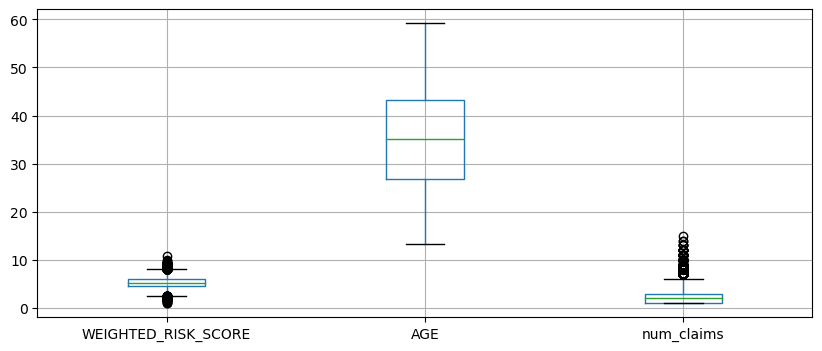

In [29]:
# outliers

data[continuous_num].boxplot(figsize=(10,4))
plt.show()

The outliers for WEIGHTED_RISK_SCORE and num_claims are reasonable, unless there is a min/max limits, we just keep the outlier for now.<br>
Decision trees-based models are robust to outliers.

In [30]:
# feature magnitude

data.describe()

,WEIGHTED_RISK_SCORE,DIABETES,OPIOID_RX,CANCER,AGE,num_claims,LOS_DESCR_Emergency_Room,LOS_DESCR_Inpatient,LOS_DESCR_Outpatient,LOS_DESCR_Professional,LOS_DESCR_Telehealth,LOS_DESCR_Urgent_Care,y
count,41965.000000,41965.000000,41965.000000,41965.000000,41965.000000,36941.000000,36941.000000,36941.000000,36941.000000,36941.000000,36941.000000,36941.000000,41965.000000
mean,5.243774,0.092101,0.054379,0.002359,35.143200,2.484665,0.266289,0.081129,0.279716,1.380093,0.231396,0.246041,0.021065
std,1.033833,0.289171,0.226766,0.048514,10.001654,1.468276,0.530436,0.290802,0.580608,1.081219,0.473557,0.495369,0.143603
min,1.112207,0.000000,0.000000,0.000000,13.276511,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.547935,0.000000,0.000000,0.000000,26.704227,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,5.229487,0.000000,0.000000,0.000000,35.028494,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,5.931579,0.000000,0.000000,0.000000,43.210935,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
max,10.810277,1.000000,1.000000,1.000000,59.209467,15.000000,5.000000,4.000000,7.000000,8.000000,3.000000,4.000000,1.000000


Features are in different ranges or scales.

<a id='EDA'></a>
<h1 style="background-color:#fbcc54;font-family:monospace;font-size:200%;text-align:center">4. EDA </h1>

<a id='Read_Dataset'></a>
<h3 style="color:blue">4.1 Target</h3>

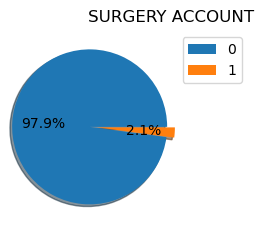

In [31]:
fig = data['y'].value_counts().plot(kind="pie", autopct='%1.1f%%',
                                shadow=True, explode=[0.05, 0.05], 
                                legend=True,  ylabel='', labeldistance=None, 
                                title='train data',figsize=(2, 3))
fig.set_xlim(0, 2)
fig.set_title('SURGERY ACCOUNT')
plt.show()

Checking target distribution, showing it is an imbalanced class.

<a id='Numerical_Features'></a>
<h3 style="color:blue">4.2 Numerical Features</h3> 

### Continuous Numerical Features Distribution

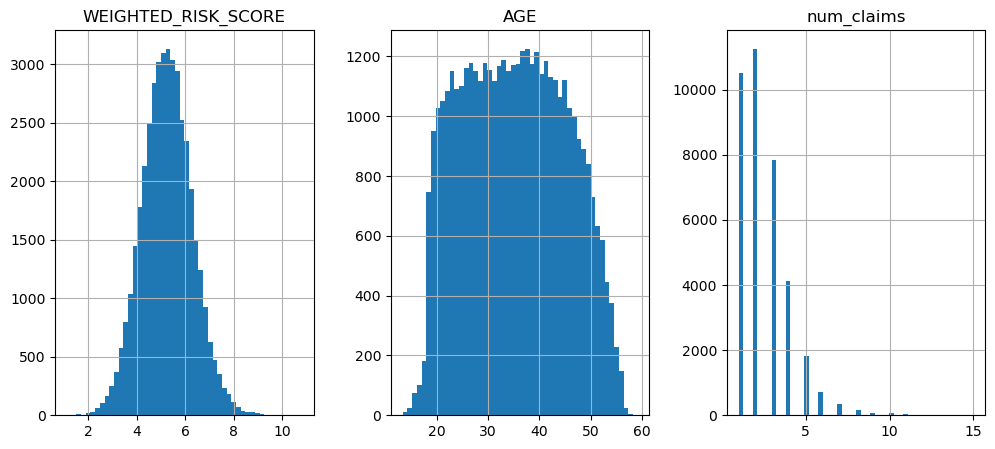

In [32]:
# Let's make a histogram to get familiar with the
# variable distribution.
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
data[continuous_num].hist(bins=50,ax=axs)
plt.show()

num_claims need transform if run logistic regression model.

### Distribution of continuous numeric features vs target class (0,1)

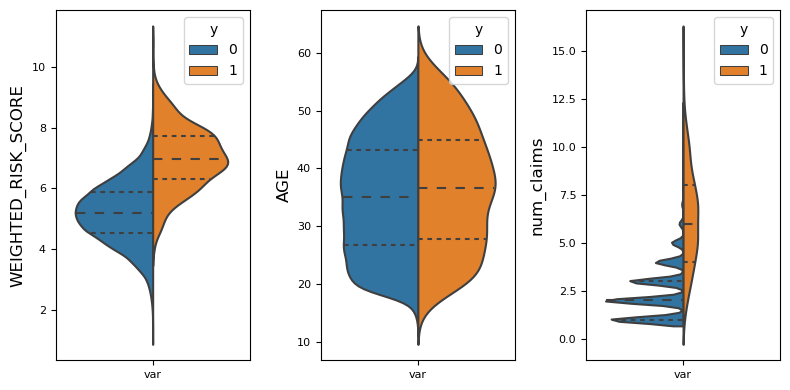

In [33]:
numdf = data.loc[:,('y','WEIGHTED_RISK_SCORE', 'AGE', 'num_claims')]
numdf['var']='var'
fig, axes = plt.subplots(1,3,figsize = (8,4), dpi = 100)
for i,col in enumerate(continuous_num):
    c = i%3
    ax=sns.violinplot(x='var', y=col, data=numdf, hue='y', split=True, inner='quart',ax=axes[c])
    ax.set(xlabel=None)
    ax.set_ylabel(f'{col}', fontsize=12)
    ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show();

risk socore and num of claims show variance vs target

### Discrete features

In [34]:
discrete_num

['DIABETES',
 'OPIOID_RX',
 'CANCER',
 'LOS_DESCR_Emergency_Room',
 'LOS_DESCR_Inpatient',
 'LOS_DESCR_Outpatient',
 'LOS_DESCR_Professional',
 'LOS_DESCR_Telehealth',
 'LOS_DESCR_Urgent_Care']

### Distribution of discrete features vs target class (0,1)
#### Any features  near 2.1% surgery rate are our target patients characteristics

In [35]:
def plot_counts(df, category_col, target_col, length, height, fontsize, show_percentages=True, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(length, height))
        ax = fig.add_subplot(111)
    sns.countplot(x=category_col, hue=target_col, data=df, ax=ax)
    if show_percentages:
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height / len(df) * 100:.1f}%', 
                        xy=(p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 5),
                        textcoords='offset points', fontsize=fontsize)

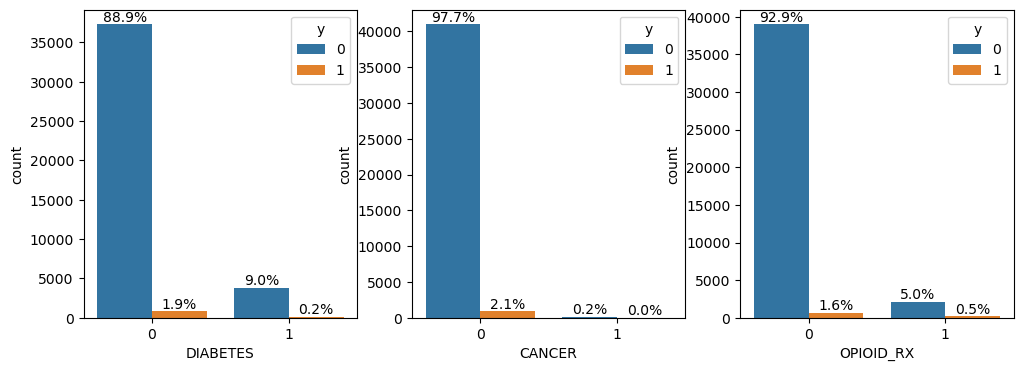

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

plot_counts(data, 'DIABETES', 'y', 3,3,10, ax=axs[0])
plot_counts(data, 'CANCER', 'y', 3,3,10, ax=axs[1])
plot_counts(data, 'OPIOID_RX', 'y', 3,3,10, ax=axs[2])

plt.show();

Percentage of patients with diabetes: 9.2%, surgery of diabetes patients is 0.2%<br>
Percentage of patients with cancer: 0.2%, surgery of cancer patients is 0<br>
Percentage of patients prescribed an opioid is 5.5%, surgery of patients prescribed an opioid: 0.5%<br>

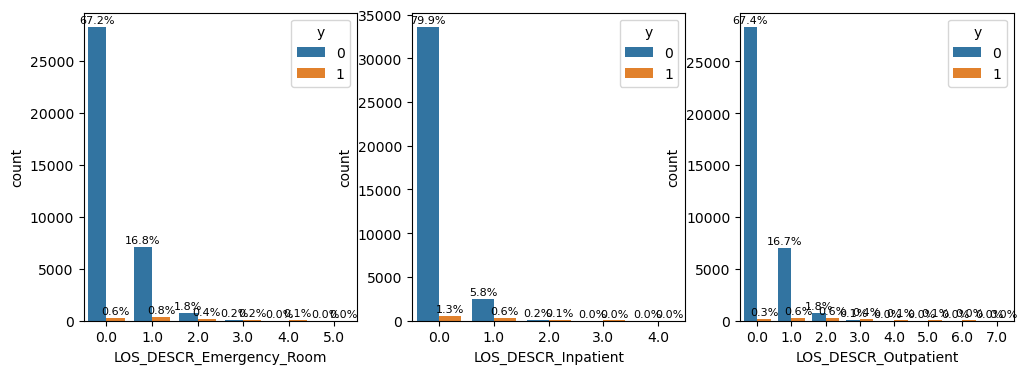

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

plot_counts(data, 'LOS_DESCR_Emergency_Room', 'y', 3,3,8, ax=axs[0])
plot_counts(data, 'LOS_DESCR_Inpatient', 'y', 3,3,8, ax=axs[1])
plot_counts(data, 'LOS_DESCR_Outpatient', 'y', 3,3,8, ax=axs[2])

plt.show();

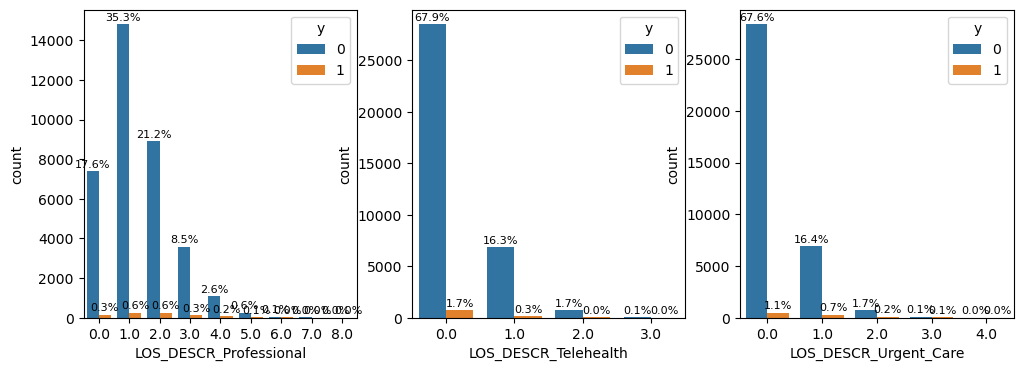

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

plot_counts(data, 'LOS_DESCR_Professional', 'y', 3,3,8, ax=axs[0])
plot_counts(data, 'LOS_DESCR_Telehealth', 'y', 3,3,8, ax=axs[1])
plot_counts(data, 'LOS_DESCR_Urgent_Care', 'y', 3,3,8, ax=axs[2])

plt.show();

More service are professional service, least service is inpatient service.

<a id='Categorical_Variables'></a>
<h3 style="color:blue">4.3 Categorical Variables</h3>

**GENDER**

**MEMBER_ID: Each patient has an identical member_id, drop the feature**

**ICD10: Mixed feature  with high cardinality, high cardinality may cause the model to over-fit, need more feature engineering tuning**

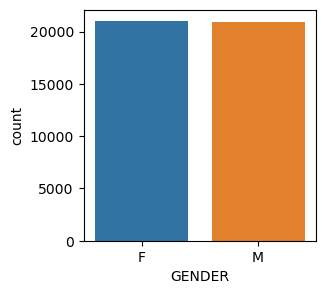

In [39]:
f, axes = plt.subplots(1,1, figsize=(3,3))

sns.countplot(x = 'GENDER',data= data)
plt.tick_params(labelsize=10)
plt.show();

#### ICD10

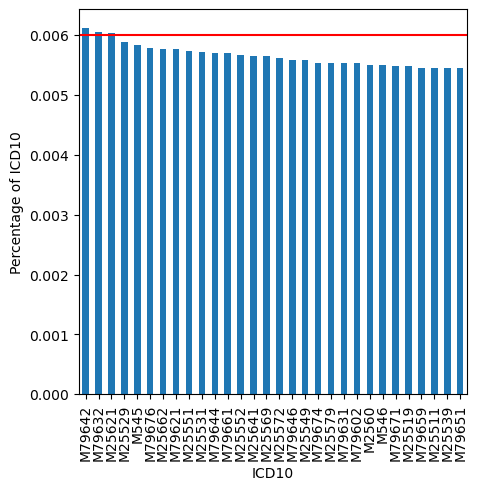

In [40]:
# The percentage of ICD10 per category.

temp_df = pd.Series(data['ICD10'].value_counts() / len(data))

# Make plot with these percentages.
f, axes = plt.subplots(1,1, figsize=(5,5))
fig = temp_df.sort_values(ascending=False).head(30).plot.bar()
fig.set_xlabel('ICD10')

# Add a line at 0.6 % to flag labels.
fig.axhline(y=0.006, color='red')
fig.set_ylabel('Percentage of ICD10')
plt.show()

In [41]:
# Let's capture the first letter of ICD10.
temp = data.copy()

temp['ICD10_C'] = temp['ICD10'].astype(str).str[0] # captures the first letter

temp['ICD10_num'] = temp['ICD10'].str.extract('(\d+)') # captures numerical part

temp[['ICD10', 'ICD10_C','ICD10_num']].head()

,ICD10,ICD10_C,ICD10_num
0,M25611,M,25611
1,Z6854,Z,6854
2,M79604,M,79604
3,M71122,M,71122
4,M25549,M,25549


In [42]:
print('Number of categories in the variable ICD10: {}'.format(
    len(temp.ICD10.unique())))

print('Number of categories in the variable ICD10_C: {}'.format(
    len(temp.ICD10_C.unique())))

print('Number of categories in the variable ICD10_num: {}'.format(
    len(temp.ICD10_num.unique())))

Number of categories in the variable ICD10: 1036
Number of categories in the variable ICD10_C: 10
Number of categories in the variable ICD10_num: 1004


### Distribution of catergorical features vs target class (0,1)

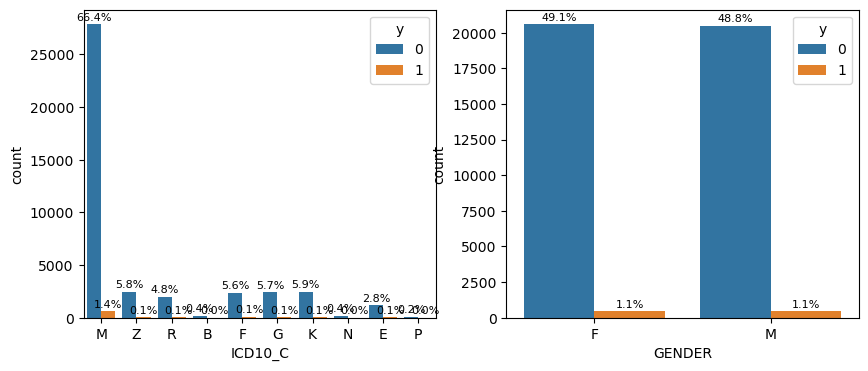

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plot_counts(temp, 'ICD10_C', 'y', 3,3,8, ax=axs[0])
plot_counts(data, 'GENDER','y', 3,3,8, ax=axs[1])

plt.show();

most of the surgery patients has M code diseases.

May be we are predicting musculoskeletal surgery. 

<a id='Dependency_between_features'></a>
<h3 style="color:blue">4.4 Dependency between features</h3>

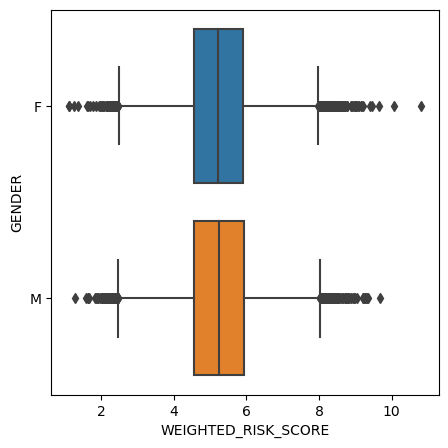

In [44]:
# Let's see the Gender vs. Monthly Income
plt.figure(figsize=(5, 5))
sns.boxplot(x = 'WEIGHTED_RISK_SCORE', y = 'GENDER', data = data)
plt.show();

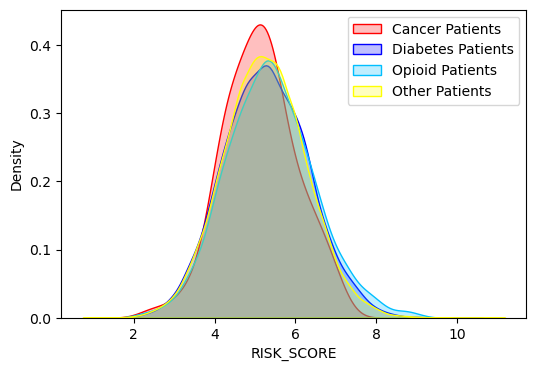

In [45]:
# filter the data include patients with diabetes
diabetes_data = data[(data['DIABETES'] == 1)]

# filter the data include patients with cancer
cancer_data = data[(data['CANCER'] == 1)]

# filter the data include patients with opioid
opioid_data = data[(data['OPIOID_RX'] == 1)]

# filter the data to only include patients without any of the diseases
other_data = data[(data['DIABETES'] == 0) & (data['CANCER'] == 0) & (data['OPIOID_RX'] == 0)]

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of a continuous variable. 
# KDE describes the probability density at different values in a continuous variable. 

plt.figure(figsize=(6,4))

sns.kdeplot(cancer_data['WEIGHTED_RISK_SCORE'], label = 'Cancer Patients', fill = True, color = 'r', legend = True)
sns.kdeplot(diabetes_data['WEIGHTED_RISK_SCORE'], label = 'Diabetes Patients', fill = True, color = 'b',legend = True)
sns.kdeplot(opioid_data['WEIGHTED_RISK_SCORE'], label = 'Opioid Patients', fill = True, color = 'deepskyblue',legend = True)
sns.kdeplot(other_data['WEIGHTED_RISK_SCORE'], label = 'Other Patients', fill = True, color = 'yellow',legend = True)

plt.xlabel('RISK_SCORE')
plt.legend()
plt.show();

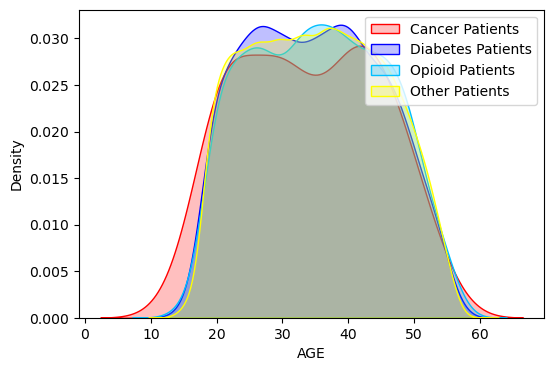

In [46]:
# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of a continuous variable. 
# KDE describes the probability density at different values in a continuous variable. 

plt.figure(figsize=(6,4))

sns.kdeplot(cancer_data['AGE'], label = 'Cancer Patients', fill = True, color = 'r', legend = True)
sns.kdeplot(diabetes_data['AGE'], label = 'Diabetes Patients', fill = True, color = 'b',legend = True)
sns.kdeplot(opioid_data['AGE'], label = 'Opioid Patients', fill = True, color = 'deepskyblue',legend = True)
sns.kdeplot(other_data['AGE'], label = 'Other Patients', fill = True, color = 'yellow',legend = True)

plt.xlabel('AGE')
plt.legend()
plt.show();

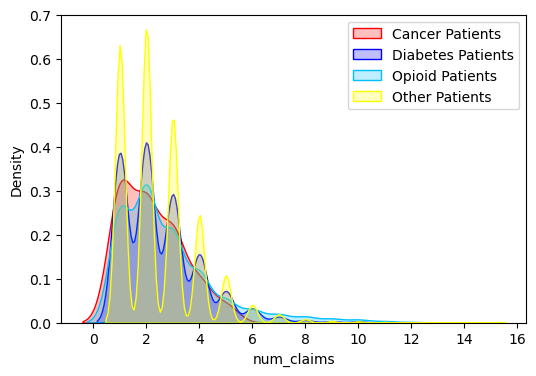

In [47]:
# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of a continuous variable. 
# KDE describes the probability density at different values in a continuous variable. 

plt.figure(figsize=(6,4))

sns.kdeplot(cancer_data['num_claims'], label = 'Cancer Patients', fill = True, color = 'r', legend = True)
sns.kdeplot(diabetes_data['num_claims'], label = 'Diabetes Patients', fill = True, color = 'b',legend = True)
sns.kdeplot(opioid_data['num_claims'], label = 'Opioid Patients', fill = True, color = 'deepskyblue',legend = True)
sns.kdeplot(other_data['num_claims'], label = 'Other Patients', fill = True, color = 'yellow',legend = True)

plt.xlabel('num_claims')
plt.legend()
plt.show();

<a id="Correlation_between_features"></a>
<h3 style="color:blue">4.5 Correlation between features</h3>

### Correlation between continuous cumeric features

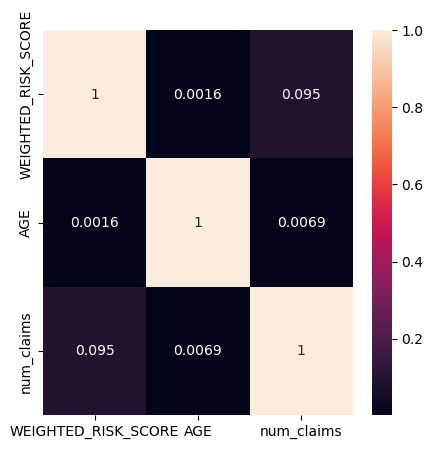

In [48]:
# fill the missing for numerical data
imp_mean = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
num_df = pd.DataFrame(imp_mean.fit_transform(data[continuous_num]))
num_df.columns = data[continuous_num].columns.tolist()

correlations = num_df.corr()
f, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(correlations, annot = True)
plt.show();

### Multicollinearity

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data[continuous_num].columns.tolist()

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(num_df.values, i)
for i in range(len(num_df.columns))]
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
0,WEIGHTED_RISK_SCORE,10.279949
1,AGE,9.237166
2,num_claims,2.848554


Variables have a low Pearson correlation but high VIF, this suggests that although the linear relationship between the two variables is weak, multicollinearity exists between the continues variables. Since there is multicollinearity, we will not use logistic regression as base model, we will run random forest as our base model.

### Correlation between Numeric and Categorical features

interval columns not set, guessing: ['WEIGHTED_RISK_SCORE', 'DIABETES', 'OPIOID_RX', 'CANCER', 'AGE', 'num_claims', 'LOS_DESCR_Emergency_Room', 'LOS_DESCR_Inpatient', 'LOS_DESCR_Outpatient', 'LOS_DESCR_Professional', 'LOS_DESCR_Telehealth', 'LOS_DESCR_Urgent_Care', 'y']


The number of unique values of variable ICD10 is large: 1036. Are you sure this is not an interval variable? Analysis for pairs of variables including ICD10 can be slow.


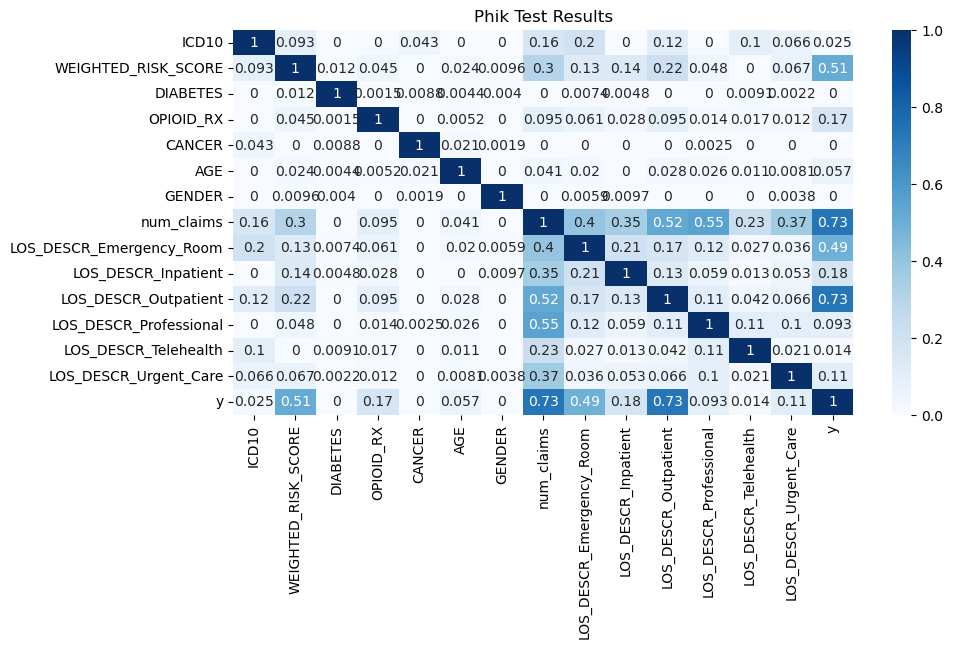

In [50]:
# selected features from above statistical analysis

result = data.drop('MEMBER_ID', axis=1).phik_matrix()

fig = plt.figure(figsize=(10,5))
sns.heatmap(result, cmap='Blues', annot=True)
plt.title('Phik Test Results')
plt.show()

Target has strong association with los_outpatient, num_claims, risk_score and los_emergency.



<a id="EDA_Summery"></a>
<h3 style="color:red">4.6 EDA Summery</h3>

<br>
1. Independent variables

    There are 9 discrete numerical variables, 3 are disease related, 6 are service location related.

    There are 3 continuous numerical variables ['WEIGHTED_RISK_SCORE', 'AGE', 'num_claims']
        
        There is missing data in num_claims and los_descr. We would fillna with 0 representing there is no claims issued.

    There are 3 categorical variables ['MEMBER_ID', 'ICD10', 'GENDER']
    
       - ICD10: Mixed feature with high cardinality, high cardinality may cause the model to over-fit, need more feature engineering tuning.
       - Drop MEMBER_ID
<br>
2. Target is surgery or not, the base rate is 2.1%<br>

        Use stratify data split, balanced weight in random forest, scale_pos_weight in XGBoost to deal imbalanced data.

<br>
3. Linear correlation and multicolinearity

       - Continuous variables have a low Pearson correlation but high VIF, this suggests that although the linear relationship between the two variables is weak, multicollinearity exists between the continues variables. Since there is multicollinearity, we will not use logistic regression as base model, we will run random forest as our base model.
<br>
4. Based on PhiK, Target has strong association with los_outpatient, num_claims, risk_score and los_emergency.

<a id='Feature_Engineering'></a>
<h1 style="background-color:#fbcc54;font-family:monospace;font-size:200%;text-align:center">5. Data Preprocessing</h1>

<a id="Train/Test_data_ready_for_modeling"></a>
<h3 style="color:blue">5.1 Train/Test data ready for modeling</h3>

Train Dataset: Used to fit the machine learning model.<br>
Test Dataset: Used to evaluate the fit machine learning model.

In [51]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).drop(['MEMBER_ID'], axis=1).columns
data = data.drop('MEMBER_ID', axis=1)
X = data.drop('y', axis=1)
y = data['y']
le = preprocessing.LabelEncoder()
label_encoder = le.fit(y)
y = label_encoder.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

<a id="Categorical_encoders_tuning_on_ICD10"></a>
<h3 style="color:blue">5.2 Categorical encoders tuning on ICD10</h3>

In [52]:
numeric_features

Index(['WEIGHTED_RISK_SCORE', 'DIABETES', 'OPIOID_RX', 'CANCER', 'AGE',
       'num_claims', 'LOS_DESCR_Emergency_Room', 'LOS_DESCR_Inpatient',
       'LOS_DESCR_Outpatient', 'LOS_DESCR_Professional',
       'LOS_DESCR_Telehealth', 'LOS_DESCR_Urgent_Care'],
      dtype='object')

In [53]:
categorical_features

Index(['ICD10', 'GENDER'], dtype='object')

In [54]:
encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
               ce.basen.BaseNEncoder,
               ce.binary.BinaryEncoder,
                ce.cat_boost.CatBoostEncoder,
                ce.hashing.HashingEncoder,
                ce.helmert.HelmertEncoder,
                ce.james_stein.JamesSteinEncoder,
                ce.one_hot.OneHotEncoder,
                ce.leave_one_out.LeaveOneOutEncoder,
                ce.m_estimate.MEstimateEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.sum_coding.SumEncoder,
                ce.target_encoder.TargetEncoder,
                ce.woe.WOEEncoder
                ]
for encoder in encoder_list: #for a, b, c in zip(A, B, C):
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())])
    
    ICD10_transformer = Pipeline(steps=[('woe', encoder())])
    
    binary_transformer = Pipeline(steps=[('ordinal', OneHotEncoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', ICD10_transformer, ['ICD10']),
        ('bin', binary_transformer, ['GENDER'])])
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=500, random_state=5))])
    
    model = pipe.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print(encoder)
    print(f1_score(y_train, y_train_pred, average='macro'))
    print(f1_score(y_test, y_test_pred, average='macro'))

Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)


<class 'category_encoders.backward_difference.BackwardDifferenceEncoder'>
1.0
0.6404942169725801
<class 'category_encoders.basen.BaseNEncoder'>
1.0
0.8590097144564337
<class 'category_encoders.binary.BinaryEncoder'>
1.0
0.8590097144564337
<class 'category_encoders.cat_boost.CatBoostEncoder'>
0.9624929173576064
0.8495675300134342
<class 'category_encoders.hashing.HashingEncoder'>
1.0
0.8564303231977104


Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)


<class 'category_encoders.helmert.HelmertEncoder'>
1.0
0.7689719920173809
<class 'category_encoders.james_stein.JamesSteinEncoder'>
1.0
0.8330988378003671
<class 'category_encoders.one_hot.OneHotEncoder'>
1.0
0.8391835745866393
<class 'category_encoders.leave_one_out.LeaveOneOutEncoder'>
0.9636799141144061
0.8541585081585081
<class 'category_encoders.m_estimate.MEstimateEncoder'>
1.0
0.8318338628899544
<class 'category_encoders.ordinal.OrdinalEncoder'>
1.0
0.8577156177156177


Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)


<class 'category_encoders.sum_coding.SumEncoder'>
1.0
0.8367513297119902
<class 'category_encoders.target_encoder.TargetEncoder'>
1.0
0.8330411326599898
<class 'category_encoders.woe.WOEEncoder'>
1.0
0.8403253624048845


#### CatBoostEncoder and LeaveOneOutEncoder can overcome the overfitting problem. CatBoostEncoder is slightly better.

<a id='Model_Building'></a>
<h1 style="background-color:#fbcc54;font-family:monospace;font-size:200%;text-align:center">6. Model Building</h1>

#### Model Evaluator

In [55]:
class ModelEvaluatorThreshold:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def evaluate(self, title):
        y_train_proba = self.model.predict_proba(self.X_train)
        y_test_proba = self.model.predict_proba(self.X_test)

        y_test_pred = np.zeros(len(y_test_proba), dtype=int)
        y_test_pred[y_test_proba[:,0]<=0.5] = 1

        thresholds = np.linspace(0.01,0.99,10)
        # thresholds = np.linspace(0, 1, 10)

        precision = []
        recall = []
        f1 = []

        for t in thresholds:
            y_test_pred = np.zeros(len(y_test_proba), dtype=int)
            y_test_pred[y_test_proba[:,1]>t] = 1
            # y_test_pred = (y_test_proba[:, 1] > t).astype(int)
            precision.append(precision_score(self.y_test, y_test_pred))
            recall.append(recall_score(self.y_test, y_test_pred))
            f1.append(f1_score(self.y_test, y_test_pred))

        plt.plot(thresholds, precision, label = "precision")
        plt.plot(thresholds, recall, label = "recall")
        plt.plot(thresholds, f1, label = "f1_score")
        plt.xlabel('Thresholds')
        plt.ylabel('Scores')
        plt.title(title)
        plt.ylim([0,1])
        plt.legend()
        plt.show()

In [56]:
class ConfusionMatrixVisualizer:
    def __init__(self, model, X_test, y_test, title='Confusion Matrix'):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.title = title
    
    def generate_confusion_matrix(self):
        y_pred = self.model.predict(self.X_test)
        cf_matrix = confusion_matrix(self.y_test, y_pred)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
        plt.title(self.title)
        plt.show()

<a id="Random_Forest_and_Random_Search"></a>
<h3 style="color:blue">6.1 Random Forest and Random Search</h3> 

Since we have imbalanced dataset, tried to predict with balanced class weights.

In [57]:
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())])
    
ICD10_transformer = Pipeline(steps=[('woe', ce.cat_boost.CatBoostEncoder())])
    
binary_transformer = Pipeline(steps=[('ordinal', ce.ordinal.OrdinalEncoder())])
    
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', ICD10_transformer, ['ICD10']),
        ('bin', binary_transformer, ['GENDER'])])
    
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(class_weight='balanced', random_state=5))])


In [58]:
# determine the hyperparameter space
# we use stats to sample from distributions

param_grid =     {
    'classifier__bootstrap': [True, False],
     'classifier__max_depth': [20, 30, 40, 50, 60],
     'classifier__min_samples_leaf': [2, 4, 6, 8, 10],
     'classifier__min_samples_split': [2, 5, 10],
     'classifier__n_estimators': [500, 600, 800, 900]}


# set up the search
search_rf = RandomizedSearchCV(
    pipe, # the model
    param_grid, # hyperparam space
    scoring='average_precision', # metric to optimize
    cv=2, # I do 2 to speed things up, 5 would be better as the dataset is quite small
    n_iter = 5, # I do 5 to speed things up, but for randomized search 60 has been shown to find the optimal hyperparameters
    random_state=5, # reproducibility
    refit=True, # this fits the model with the best hyperparams to the entire training set after the hyperparam search
)

# find best hyperparameters
search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['WEIGHTED_RISK_SCORE', 'DIABETES', 'OPIOID_RX', 'CANCER', 'AGE',
       'num_claims', 'LOS_DESCR_Emergency_Room', 'LOS_DESCR_Inpatient',
       'LOS_DESCR...
                                             ('classifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=5))]),
                   n_iter=5,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [20, 30, 40,
                                                                  50, 60],
                                        'classifier__min_samples_leaf': [2, 4,
                                                                         6, 8,
                                                                         10],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [500, 600,
                                                                     800,
                                                                     900]},
                   random_state=5, scoring='average_precision')

In [59]:
search_rf.best_params_

{'classifier__n_estimators': 600,
 'classifier__min_samples_split': 2,
 'classifier__min_samples_leaf': 4,
 'classifier__max_depth': 30,
 'classifier__bootstrap': True}

In [60]:
# Now let's get the benchmark performance on train and test

X_train_preds_rf = search_rf.predict_proba(X_train)[:,1]
X_test_preds_rf = search_rf.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds_rf))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds_rf))

Train roc_auc:  0.9983656082241203
Test roc_auc:  0.9815060458028706


In [61]:
y_test_pred_rf = search_rf.predict(X_test)
y_train_pred_rf = search_rf.predict(X_train)

print('report for random forest training set')
print("====================================")
print(classification_report(y_train, y_train_pred_rf))
print('report for random forest testing set')
print("====================================")
print(classification_report(y_test, y_test_pred_rf))

report for random forest training set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     32865
           1       0.78      0.92      0.84       707

    accuracy                           0.99     33572
   macro avg       0.89      0.96      0.92     33572
weighted avg       0.99      0.99      0.99     33572

report for random forest testing set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8216
           1       0.71      0.75      0.73       177

    accuracy                           0.99      8393
   macro avg       0.85      0.87      0.86      8393
weighted avg       0.99      0.99      0.99      8393



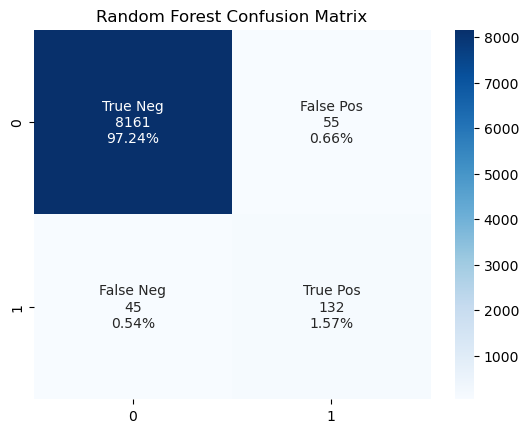

In [62]:
cmv = ConfusionMatrixVisualizer(search_rf, X_test, y_test, title='Random Forest Confusion Matrix')
cmv.generate_confusion_matrix()

Default threshold = 0.5:<br>
Out of the 8206 ‘not surgery’ predictions (first column), the classifier predicted correctly 8161 of them.<br>
Out of the 187 ‘surgery’ predictions (second column), the classifier predicted correctly 132 of them.<br>
Out of all 8393 patients, the classifier predicted correctly 8293 of them.<br>

There is 10491 test without label, we want to select 100 patients to call. 

Actually, our dataset is imbalanced, and machine learning classifiers trained on imbalanced data are prone to overpredict the majority class. This leads to a larger misclassification rate for the minority class, which in many real-world applications is the class we are interested in. The default classification threshold 0.5 is often not ideal for imbalanced data, and it is a good strategy to adjust it.

To optimize the minority class, let's apply threshold optimization methods.

### Threshold optimization methods

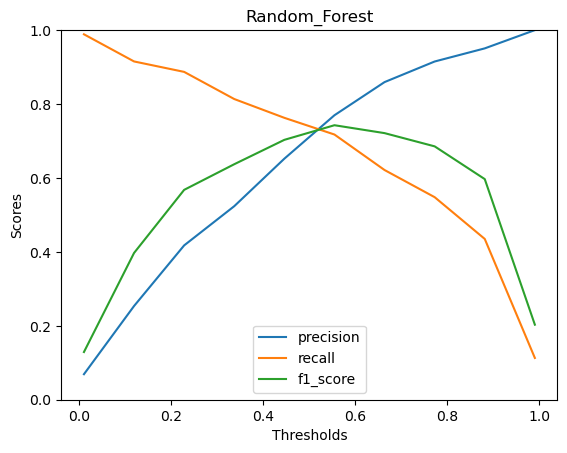

In [63]:
model_evaluator = ModelEvaluatorThreshold(search_rf, X_train, X_test, y_train, y_test)
model_evaluator.evaluate('Random_Forest')

In [64]:
y_pred_opt_0 = (search_rf.predict_proba(X_test)[:, 1] > 0.8).astype('float')
confusion_matrix(y_test, y_pred_opt_0)

array([[8208,    8],
       [  85,   92]], dtype=int64)

From the fig we see that precision increases with the increasing of threshold.

At threshold =0.8, presicion is 92%. 

Out of all 8393 patients, the classifier predicted 100 positive, 92 are correct.

There is 10491 test without label, we want to select 100 patients to call. We want to get the number of true positive near 100.
We can increase the threshold further. 

In [65]:
y_pred_opt_1 = (search_rf.predict_proba(X_test)[:, 1] > 0.85).astype('float')
confusion_matrix(y_test, y_pred_opt_1)

array([[8212,    4],
       [  95,   82]], dtype=int64)

At threshold =0.85, presicion is 95%.

Out of all 8393 patients, the classifier predicted 86 positive, 82 are correct.

Since there is 10491 test without label, the classifier can predict 107 positive patients, 102 are correct. 

### Feature Importances

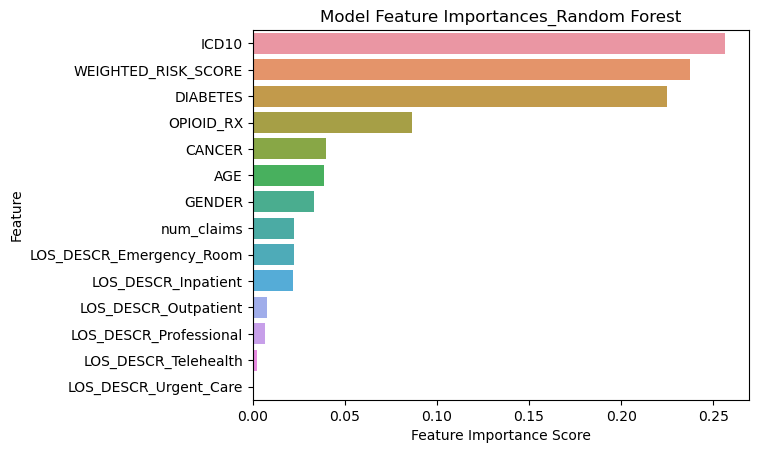

In [66]:
importance = pd.Series(search_rf.best_estimator_['classifier'].feature_importances_)
importance.sort_values(inplace=True, ascending=False)
feature_names = data.drop(['y'], axis=1).columns.tolist()
n_features = search_rf.best_estimator_['classifier'].n_features_in_

#fig, ax = plt.subplots()
#ax.bar(feature_names, importance)
sns.barplot(x=importance, y=feature_names)
# Customize the plot
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Model Feature Importances_Random Forest')
plt.show()

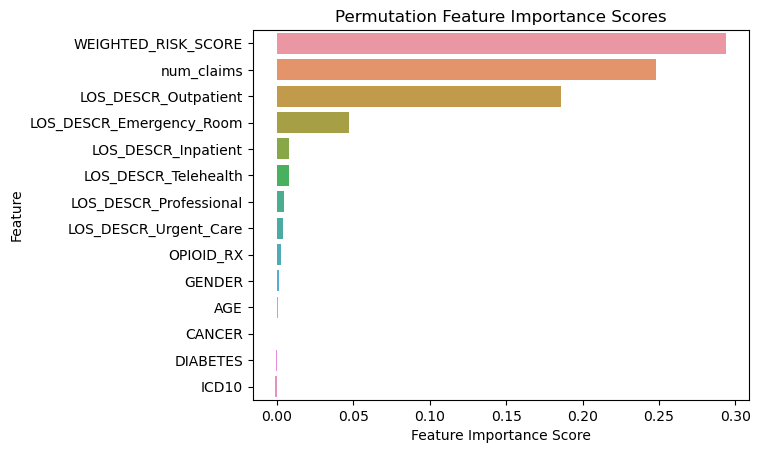

In [67]:
from sklearn.inspection import permutation_importance
r = permutation_importance(search_rf, X_test, y_test,
                           n_repeats=10,
                           random_state=0)
perm = pd.DataFrame(columns=['AVG_Importance'], index=[i for i in X_train.columns])
perm['AVG_Importance'] = r.importances_mean
# Sort the feature importance scores in descending order
perm = perm.sort_values(by='AVG_Importance', ascending=False)
# Create a bar plot of the feature importance scores
sns.barplot(x=perm['AVG_Importance'], y=perm.index)

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance Scores')
plt.show()

Tree-based models have a strong tendency to overestimate the importance of continuous numerical or high cardinality categorical features. <br>
- model based feature importance: ICD10, WEIGHTED_RISK_SCORE, Diabetes, and opioid_rx<br>
- permutation feature importance: WEIGHTED_RISK_SCORE, num_claims, LOS_outpatient

<a id="XGBoost_Classifer_and_Random_Search"></a>
<h3 style="color:blue">6.2 XGBoost Classifer and Random Search</h3> 

when add parameter to deal imbalanced data ('classifier__scale_pos_weight':[1, 10, 25, 50, 75, 99, 100, 1000])

In [68]:
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(seed=0, random_state=5, n_jobs=-1))])

param_grid = { 
    # deal imbalanced data 
    'classifier__scale_pos_weight':[1, 10, 25, 50, 75, 99, 100, 1000],
    'classifier__max_depth': [2, 4, 6, 8, 10, 15, 20],
    # Percentage of columns to be randomly samples for each tree.
    "classifier__colsample_bytree": [ 0.2, 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "classifier__reg_alpha": [0, 0.5, 1, 5, 6, 7, 8],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "classifier__reg_lambda": [0, 0.5, 1, 5],
    "classifier__learning_rate": [0.01, 0.03, 0.1]
    }

# set up the search
search_xgb = RandomizedSearchCV(
    pipe_xgb, # the model
    param_grid, # hyperparam space
    scoring='average_precision', # metric to optimize
    cv=2, # I do 2 to speed things up, 5 would be better as the dataset is quite small
    n_iter = 5, # I do 5 to speed things up, but for randomized search 60 has been shown to find the optimal hyperparameters
    random_state=5, # reproducibility
    refit=True, # this fits the model with the best hyperparams to the entire training set after the hyperparam search
)

# find best hyperparameters
search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['WEIGHTED_RISK_SCORE', 'DIABETES', 'OPIOID_RX', 'CANCER', 'AGE',
       'num_claims', 'LOS_DESCR_Emergency_Room', 'LOS_DESCR_Inpatient',
       'LOS_DESCR...
                                                            random_state=5, ...))]),
                   n_iter=5,
                   param_distributions={'classifier__colsample_bytree': [0.2,
                                                                         0.3,
                                                                         0.5,
                                                                         0.8],
                                        'classifier__learning_rate': [0.01,
                                                                      0.03,
                                                                      0.1],
                                        'classifier__max_depth': [2, 4, 6, 8,
                                                                  10, 15, 20],
                                        'classifier__reg_alpha': [0, 0.5, 1, 5,
                                                                  6, 7, 8],
                                        'classifier__reg_lambda': [0, 0.5, 1,
                                                                   5],
                                        'classifier__scale_pos_weight': [1, 10,
                                                                         25, 50,
                                                                         75, 99,
                                                                         100,
                                                                         1000]},
                   random_state=5, scoring='average_precision')

In [69]:
search_xgb.best_params_

{'classifier__scale_pos_weight': 100,
 'classifier__reg_lambda': 0.5,
 'classifier__reg_alpha': 0.5,
 'classifier__max_depth': 20,
 'classifier__learning_rate': 0.1,
 'classifier__colsample_bytree': 0.8}

In [70]:
# Now let's get the benchmark performance on train and test

X_train_preds_xgb = search_xgb.predict_proba(X_train)[:,1]
X_test_preds_xgb = search_xgb.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds_xgb))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds_xgb))

Train roc_auc:  0.9998168324363245
Test roc_auc:  0.9804302202124557


In [71]:
y_test_pred_xgb = search_xgb.predict(X_test)
y_train_pred_xgb = search_xgb.predict(X_train)

print('report for training set')
print("====================================")
print(classification_report(y_train, y_train_pred_xgb))
print('report for testing set')
print("====================================")
print(classification_report(y_test, y_test_pred_xgb))

report for training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32865
           1       0.95      0.97      0.96       707

    accuracy                           1.00     33572
   macro avg       0.97      0.99      0.98     33572
weighted avg       1.00      1.00      1.00     33572

report for testing set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8216
           1       0.75      0.67      0.71       177

    accuracy                           0.99      8393
   macro avg       0.87      0.83      0.85      8393
weighted avg       0.99      0.99      0.99      8393



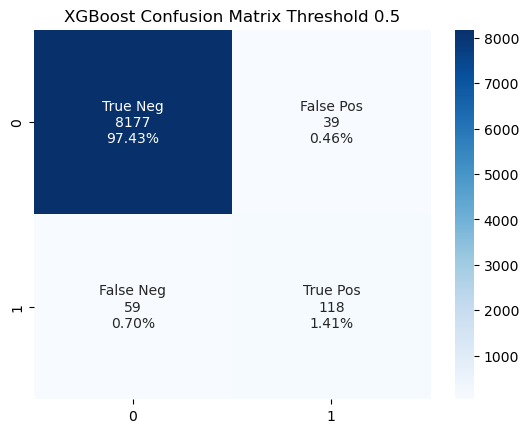

In [72]:
cmv = ConfusionMatrixVisualizer(search_xgb, X_test, y_test, title='XGBoost Confusion Matrix Threshold 0.5')
cmv.generate_confusion_matrix()

Default threshold is 0.5:
Out of the 8236 ‘not surgery’ predictions (first column), the classifier predicted correctly 8177 of them.<br>
Out of the 157 ‘surgery’ predictions (second column), the classifier predicted correctly 118 of them.<br>
Out of all 8393 patients, the classifier predicted correctly 8295 of them.<br>


### Threshold optimization methods

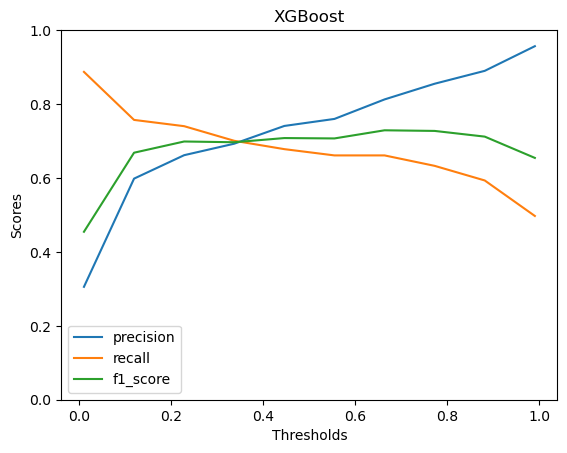

In [73]:
model_evaluator = ModelEvaluatorThreshold(search_xgb, X_train, X_test, y_train, y_test)
model_evaluator.evaluate('XGBoost')

In [74]:
y_pred_opt_0 = (search_xgb.predict_proba(X_test)[:, 1] > 0.99).astype('float')
confusion_matrix(y_test, y_pred_opt_0)

array([[8212,    4],
       [  89,   88]], dtype=int64)

From the fig we see that precision increases with the increasing of threshold.

At threshold =0.99, precision is 95.65%.

Out of all 8393 patients, the classifier predicted 92 positive, 88 are correct.

### Feature Importances

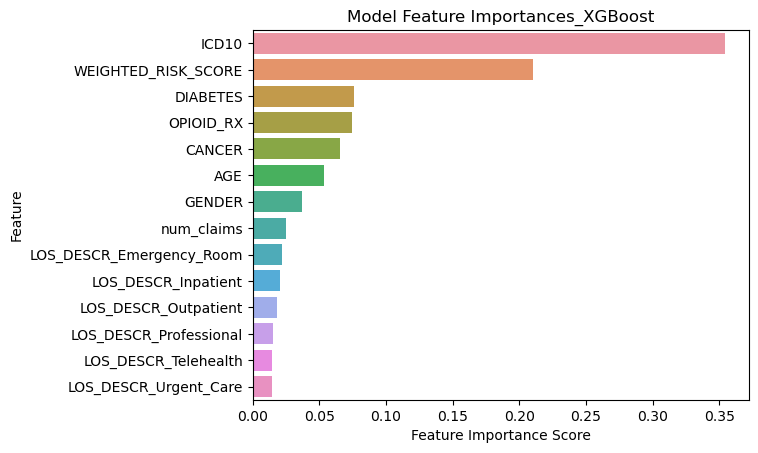

In [75]:
importance = pd.Series(search_xgb.best_estimator_['classifier'].feature_importances_)
importance.sort_values(inplace=True, ascending=False)
feature_names = data.drop(['y'], axis=1).columns.tolist()
n_features = search_rf.best_estimator_['classifier'].n_features_in_

#fig, ax = plt.subplots()
#ax.bar(feature_names, importance)
sns.barplot(x=importance, y=feature_names)
# Customize the plot
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Model Feature Importances_XGBoost')
plt.show()

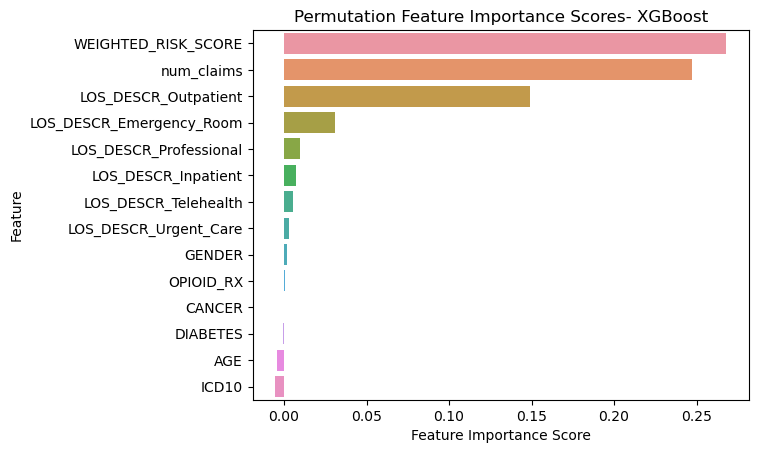

In [76]:
from sklearn.inspection import permutation_importance
r = permutation_importance(search_xgb, X_test, y_test,
                           n_repeats=10,
                           random_state=0)
perm = pd.DataFrame(columns=['AVG_Importance'], index=[i for i in X_train.columns])
perm['AVG_Importance'] = r.importances_mean
# Sort the feature importance scores in descending order
perm = perm.sort_values(by='AVG_Importance', ascending=False)
# Create a bar plot of the feature importance scores
sns.barplot(x=perm['AVG_Importance'], y=perm.index)

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance Scores- XGBoost')
plt.show();

XGBoost and Random forest got similar trend on feature importance.

<a id="Model_selection"></a>
<h3 style="color:blue">6.3 Model selection</h3>  

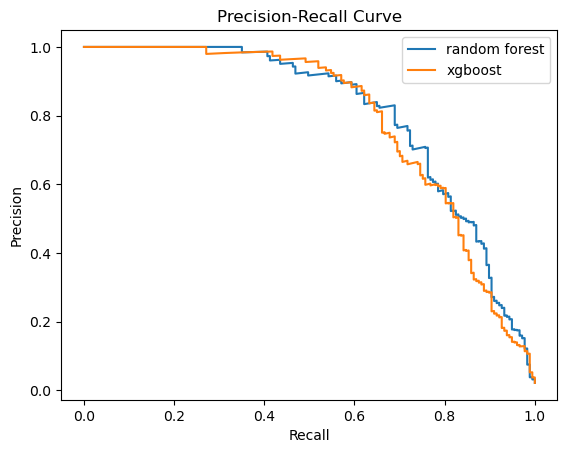

random forest AUC-PR: 0.8028836417051162
xgboost: 0.7871378820643155


In [77]:
y_test_proba_rf = search_rf.predict_proba(X_test)
y_test_proba_xgb = search_xgb.predict_proba(X_test)

y_score1 = y_test_proba_rf[:, 1]
y_score2 = y_test_proba_xgb[:, 1]
# y_true: true labels, y_score1: predicted scores of model 1, y_score2: predicted scores of model 2
precision1, recall1, _ = precision_recall_curve(y_test, y_score1)
precision2, recall2, _ = precision_recall_curve(y_test, y_score2)

# Plot the PR curves
plt.plot(recall1, precision1, label='random forest')
plt.plot(recall2, precision2, label='xgboost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Compute the AUC-PR scores
auc1 = auc(recall1, precision1)
auc2 = auc(recall2, precision2)

print('random forest AUC-PR:', auc1)
print('xgboost:', auc2)

At high presicion, xgboost has slight better recall. Therefore, xgboost is selected for our final model.

<a id="XGBoost_Classifier_and_SHAP"></a>
<h3 style="color:blue">6.4 XGBoost Classifier and SHAP</h3> 

In [78]:
X = pipe['preprocessor'].fit_transform(X, y)

In [79]:
feature_names = data.drop(['y'], axis=1).columns


In [80]:
X = pd.DataFrame(X, columns=feature_names)

In [81]:
X

,ICD10,WEIGHTED_RISK_SCORE,DIABETES,OPIOID_RX,CANCER,AGE,GENDER,num_claims,LOS_DESCR_Emergency_Room,LOS_DESCR_Inpatient,LOS_DESCR_Outpatient,LOS_DESCR_Professional,LOS_DESCR_Telehealth,LOS_DESCR_Urgent_Care
0,0.225707,-0.318502,-0.239804,-0.048628,-1.006443,-0.117271,-0.464069,-0.260546,1.364897,-0.193759,-0.452043,-0.459277,0.021065,1.0
1,-0.638649,-0.318502,-0.239804,-0.048628,-0.168468,1.135596,-0.464069,-0.260546,1.364897,1.609745,-0.452043,-0.459277,0.021065,1.0
2,0.138704,-0.318502,4.170080,-0.048628,0.264290,-0.117271,1.515667,-0.260546,-0.445861,-0.193759,-0.452043,-0.459277,0.021065,2.0
3,0.120248,-0.318502,4.170080,-0.048628,-1.694072,-0.117271,-0.464069,-0.260546,-0.445861,0.707993,-0.452043,-0.459277,0.021065,1.0
4,-1.030996,-0.318502,-0.239804,-0.048628,1.433677,-0.117271,-0.464069,3.387700,-0.445861,-0.193759,-0.452043,-0.459277,0.021065,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41960,-0.776760,-0.318502,-0.239804,-0.048628,0.311522,-0.117271,-0.464069,-0.260546,1.364897,-0.193759,-0.452043,-0.459277,0.026181,2.0
41961,-0.953492,-0.318502,-0.239804,-0.048628,-0.626994,-1.370137,-0.464069,-0.260546,-0.445861,-1.095511,-0.452043,-0.459277,0.000878,2.0
41962,1.125871,-0.318502,-0.239804,-0.048628,0.073684,-1.370137,-0.464069,-0.260546,-0.445861,-1.095511,-0.452043,-0.459277,0.030263,1.0
41963,0.802960,-0.318502,-0.239804,-0.048628,-1.091443,1.135596,3.495404,-0.260546,1.364897,-0.193759,-0.452043,-0.459277,0.008943,2.0


In [82]:
explainer = shap.TreeExplainer(search_xgb.best_estimator_['classifier'])
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Visualize a single prediction

In [83]:
#Local interpretability 
#No surgery
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [84]:
#Local interpretability
#surgery
shap.force_plot(explainer.expected_value, shap_values[-1,:], X.iloc[-1,:])

### Visualize many predictions

In [85]:
#Local interpretability - plot all
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

### SHAP Summary Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


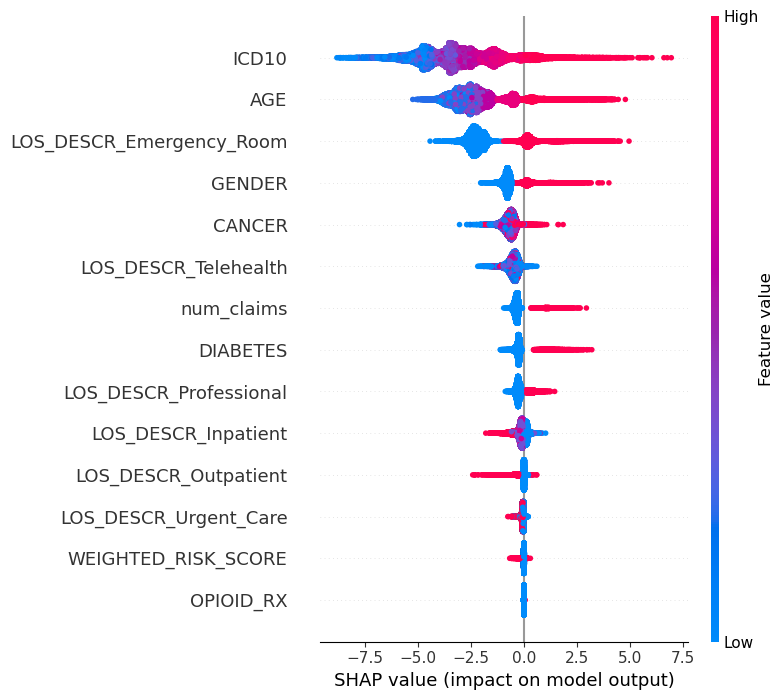

In [86]:
#Global Interpretability
shap.summary_plot(shap_values, X)

Cancer, diabetes have negetive impact on surgery.

### Bar chart of mean importance

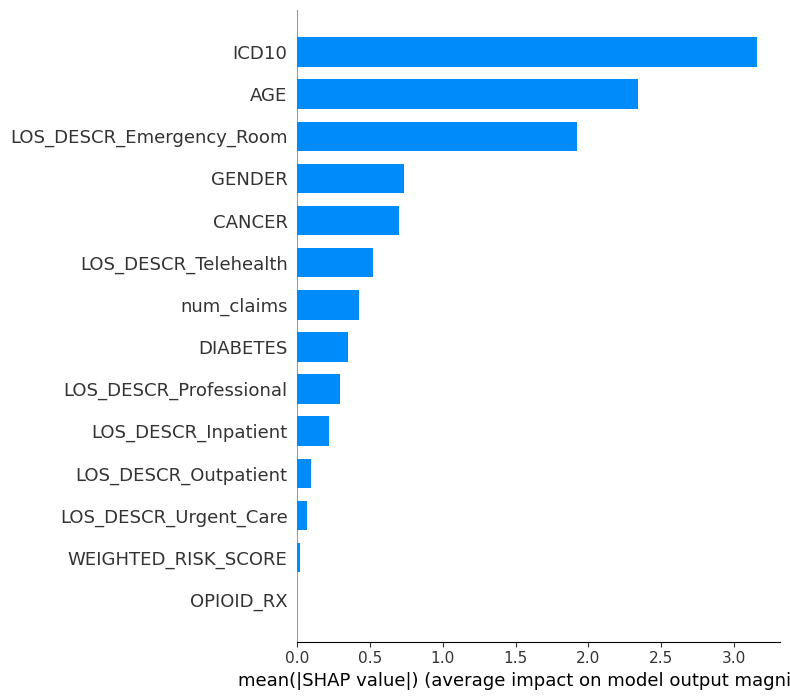

In [87]:
shap.summary_plot(shap_values, X, plot_type="bar")

### SHAP Dependence Plots

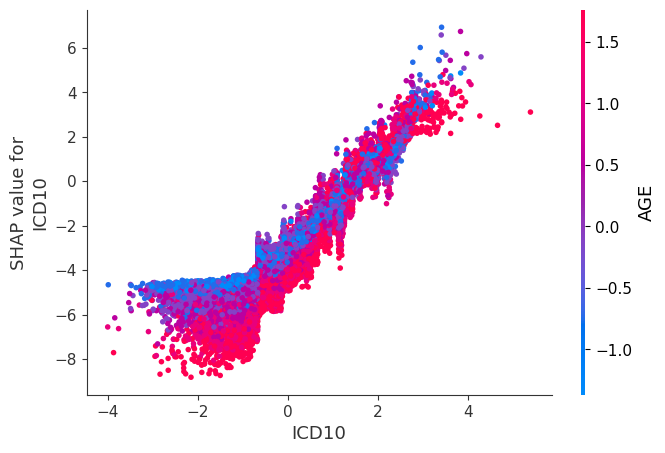

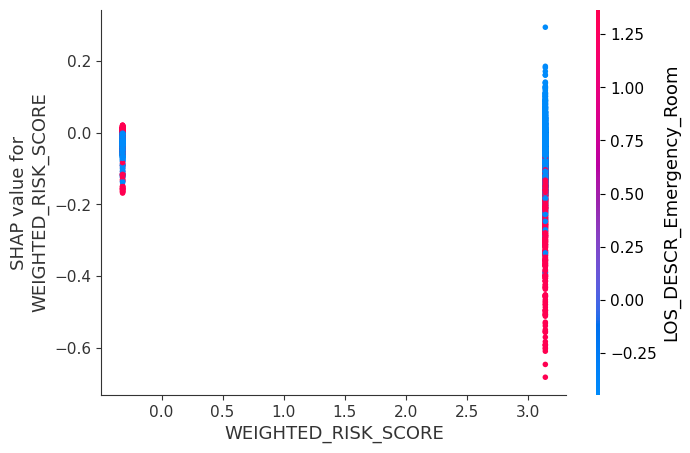

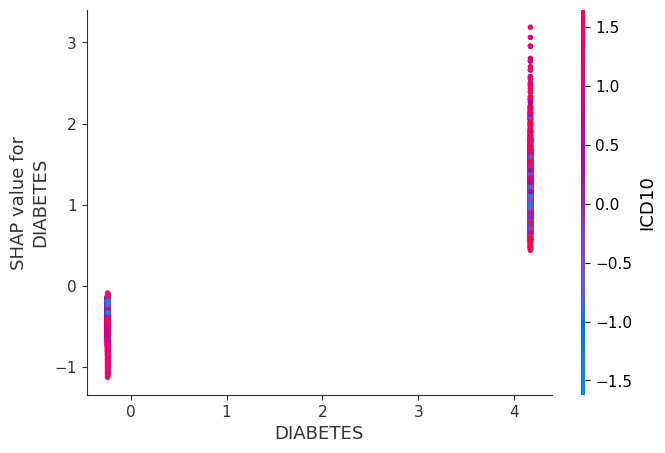

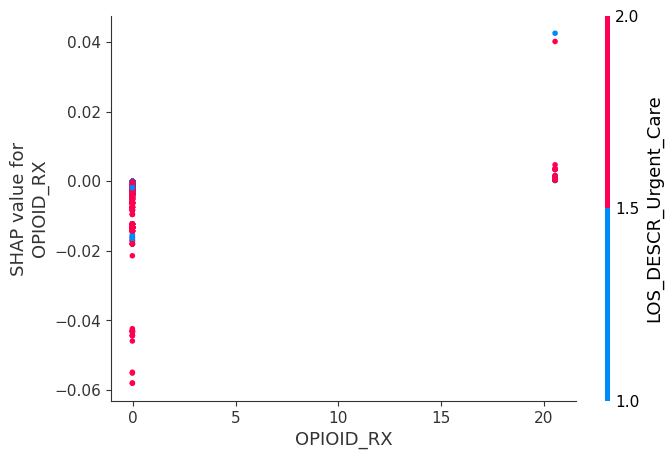

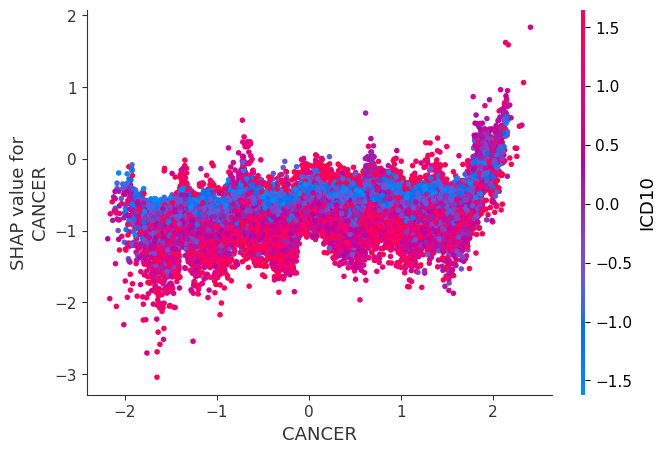

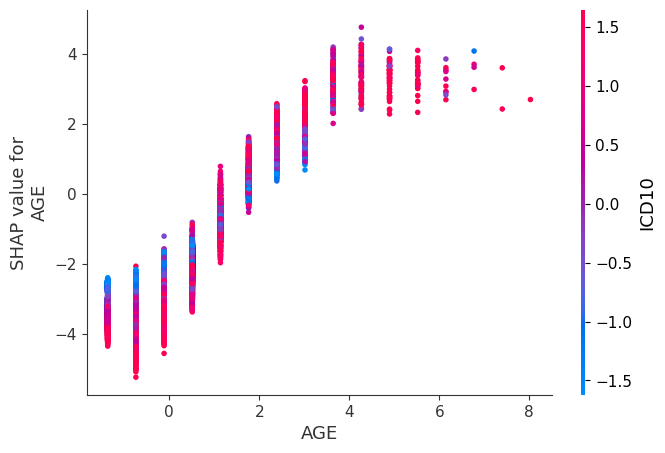

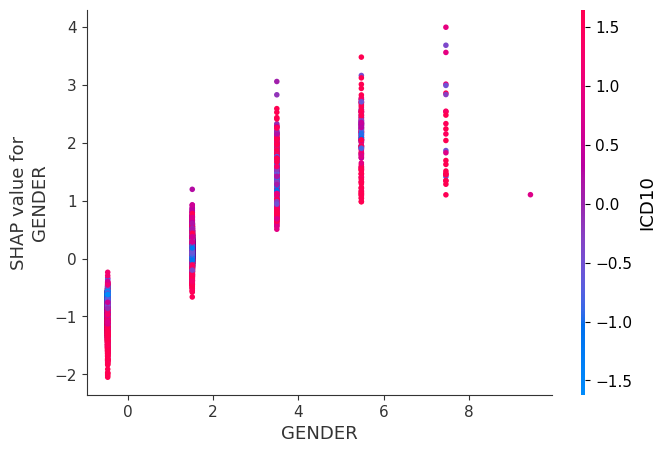

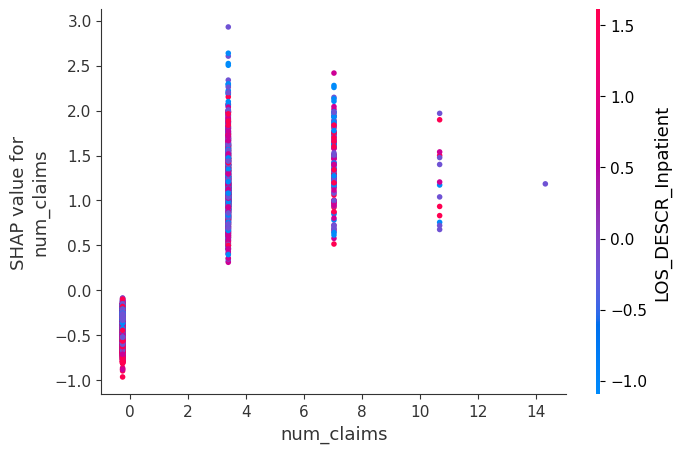

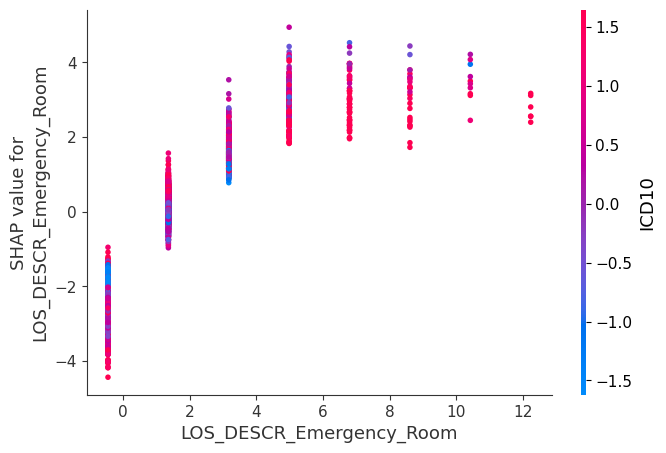

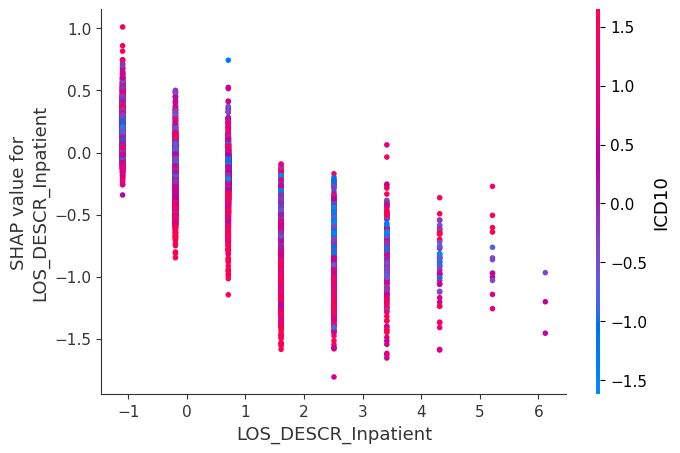

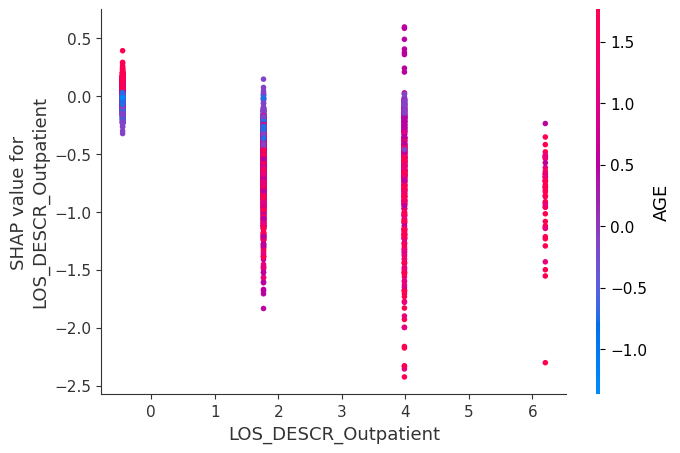

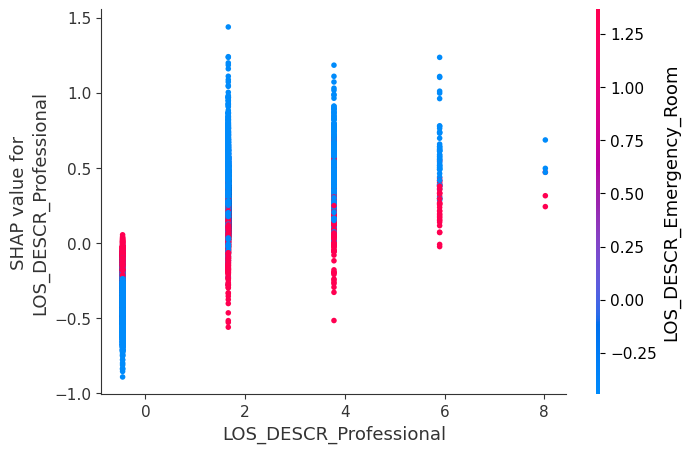

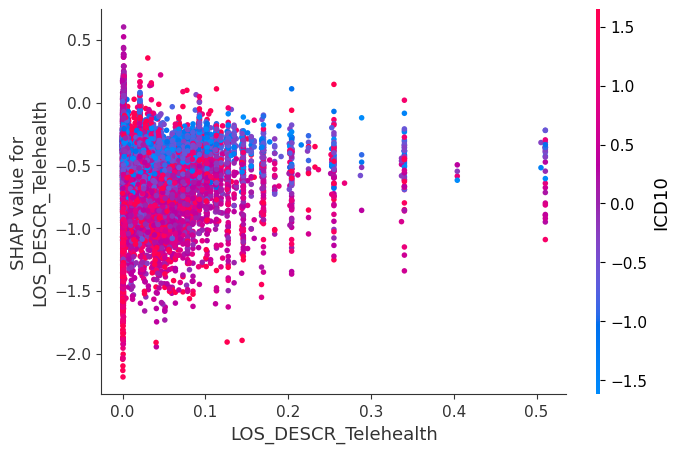

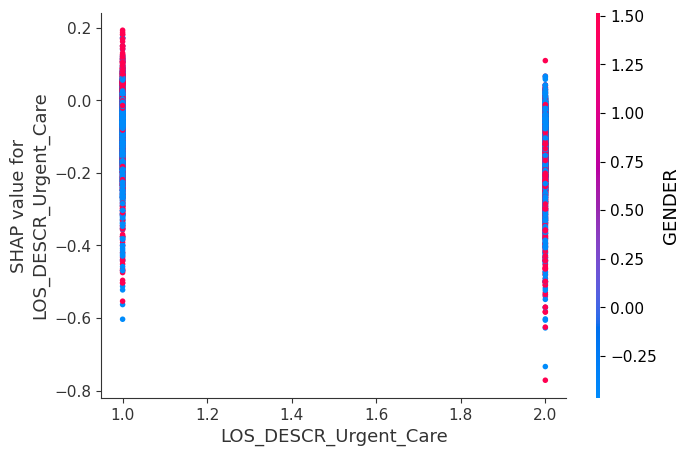

In [88]:
for name in X.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)

<a id="Summery"></a>
<h3 style="color:blue">6.5 Summery</h3> 

1. CatBoostEncoder used to overcome ICD10 cardinality.

2. Random Forest and XGBoost are selected due to the outlier, multicollinearity of the dataset. XGBoost is selected as final model.

3. Feature Importance
         
       tree-based feature importance methods tend to be biased towards high-cardinality categorical features, while permutation feature importance is unbiased towards any particular type of feature. Similarly, SHAP values can capture complex interactions between features, but can be computationally expensive to calculate. 
       
       model based feature importance: ICD10, WEIGHTED_RISK_SCORE
       permutation feature importance: WEIGHTED_RISK_SCORE, num_claims, LOS_outpatient
       SHAP feature importance: ICD10, Age, LOS_Emergency_room
       
       

<a id='Deploy'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">7. Prediction of unseen test data</h2>

<a id="Test_data_preparation"></a>
<h3 style="color:blue">7.1 Test data preparation</h3>

In [89]:
import urllib.request

urls = ["Test_data"]

dfs = []

for url in urls:
    with urllib.request.urlopen(url) as f:
        df = pd.read_csv(f, sep=" ")
        dfs.append(df)

claims_file, locations_file, surgeries_file = dfs

In [90]:
processor = ClaimsDataProcessor(claims_file, locations_file, surgeries_file)
TEST = processor.process_data()

In [91]:
TEST

,MEMBER_ID,ICD10,WEIGHTED_RISK_SCORE,DIABETES,OPIOID_RX,CANCER,AGE,GENDER,num_claims,LOS_DESCR_Emergency_Room,LOS_DESCR_Inpatient,LOS_DESCR_Outpatient,LOS_DESCR_Professional,LOS_DESCR_Telehealth,LOS_DESCR_Urgent_Care
0,C4766121375,M25632,2.222172,0,0,0,44.304646,M,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,H3257541231,M79632,5.934768,0,0,0,35.821735,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O2417120676,M70949,5.748456,0,0,0,42.082911,M,2.0,1.0,0.0,0.0,1.0,0.0,0.0
3,M6406334462,Z658,5.075615,0,0,0,52.414929,F,3.0,0.0,0.0,0.0,2.0,0.0,1.0
4,V9274610638,M545,4.060304,0,0,0,24.512456,M,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10486,F2558132237,F17218,5.484075,1,0,0,50.007862,M,6.0,2.0,0.0,0.0,2.0,1.0,1.0
10487,P2831029129,Z641,5.675289,0,0,0,32.586568,M,1.0,0.0,0.0,1.0,0.0,0.0,0.0
10488,K6789050113,M79672,5.393017,0,0,0,32.490789,F,4.0,2.0,0.0,0.0,2.0,0.0,0.0
10489,Y2760837345,M6020,6.496162,0,0,0,35.660407,F,5.0,2.0,0.0,1.0,1.0,1.0,0.0


In [92]:
surgeries_file

,MEMBER_ID,ICD10,WEIGHTED_RISK_SCORE,DIABETES,OPIOID_RX,CANCER,AGE,GENDER
0,C4766121375,M25632,2.222172,0,0,0,44.304646,M
1,H3257541231,M79632,5.934768,0,0,0,35.821735,M
2,O2417120676,M70949,5.748456,0,0,0,42.082911,M
3,M6406334462,Z658,5.075615,0,0,0,52.414929,F
4,V9274610638,M545,4.060304,0,0,0,24.512456,M
...,...,...,...,...,...,...,...,...
10486,F2558132237,F17218,5.484075,1,0,0,50.007862,M
10487,P2831029129,Z641,5.675289,0,0,0,32.586568,M
10488,K6789050113,M79672,5.393017,0,0,0,32.490789,F
10489,Y2760837345,M6020,6.496162,0,0,0,35.660407,F


<a id="Prediction"></a>
<h3 style="color:blue">7.2 Prediction</h3>

In [93]:
# Create a dataframe with member ids and predicted probabilities
test_pred_y = pd.DataFrame({
    'Member ID': TEST['MEMBER_ID'],  # Replace 'Member ID' with the actual name of the member id column
    'Predicted Probability': search_xgb.predict_proba(TEST)[:,1]
})
test_pred_y.columns = ['MEMBER ID', 'Predicted Probility']
test_pred_y.to_csv('XGBresults.csv',index=False)

In [94]:
test_pred_y

,MEMBER ID,Predicted Probility
0,C4766121375,0.000204
1,H3257541231,0.000183
2,O2417120676,0.000991
3,M6406334462,0.000321
4,V9274610638,0.000074
...,...,...
10486,F2558132237,0.007229
10487,P2831029129,0.000219
10488,K6789050113,0.000753
10489,Y2760837345,0.169645
